In [1]:
from functions import *


import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
from skimage.feature import blob_log
from apsg import *

microm2m = 1.0E-6
m2microm = 1.0E6

In [2]:
import pandas as pd
# read data from csv file

data = pd.read_csv('dataframe1.csv', delimiter=',')
data.head()

,Radius (μm),Hc (mT),TRM (A/m),D (°),I (°),Xc (μm),Yc (μm),Zc (μm),mx (Am$^2$),my (Am$^2$),mz (Am$^2$)
0,0.274359,103.133782,49233.801378,45.0,45.0,251,676,1,2.129498e-15,2.129498e-15,3.011565e-15
1,0.248128,117.159881,50420.040450,45.0,45.0,525,549,8,1.613198e-15,1.613198e-15,2.281407e-15
2,0.224965,114.074488,52016.067102,45.0,45.0,546,421,2,1.240343e-15,1.240343e-15,1.754109e-15
3,0.262240,85.659080,51627.093998,45.0,45.0,414,214,9,1.949984e-15,1.949984e-15,2.757694e-15
4,0.316949,100.989428,50513.524641,45.0,45.0,877,367,5,3.368493e-15,3.368493e-15,4.763768e-15


In [3]:
flight = 5.0  # sample-sensor distance
area = (0, 1000*microm2m, 0, 1000*microm2m)
shape = (1000,1000)
z = -flight*microm2m

f = np.matrix(regular(area, shape, z))
X = np.array(f[0])
Y = np.array(f[1])
Z = np.array(f[2])

cm = 10**(-7) # H/m  == T·m/A


# read generated sourcers
index = (data["Hc (mT)"]<=1000)
g     =  data[index]


D = np.array(g['D (°)'])
I = np.array(g['I (°)'])
Q = np.array(g['TRM (A/m)'])
R = np.array(g['Radius (μm)'])*microm2m

Xc = np.array(g['Xc (μm)'])*microm2m
Yc = np.array(g['Yc (μm)'])*microm2m
Zc = np.array(g['Zc (μm)'])*microm2m



m = cartesian_components(D, I, Q, R)
M = sensibility_matrix(X, Y, Z, Xc, Yc, Zc)


In [4]:
# data vector direct model
d = np.matmul(M, m)

#apply noise
d = noise(d, error=150.0E-9, method='fixed') # noise of 150 nT with 'fixed' method

# Reshape data vector for the map plot
d_= np.reshape(d, shape)

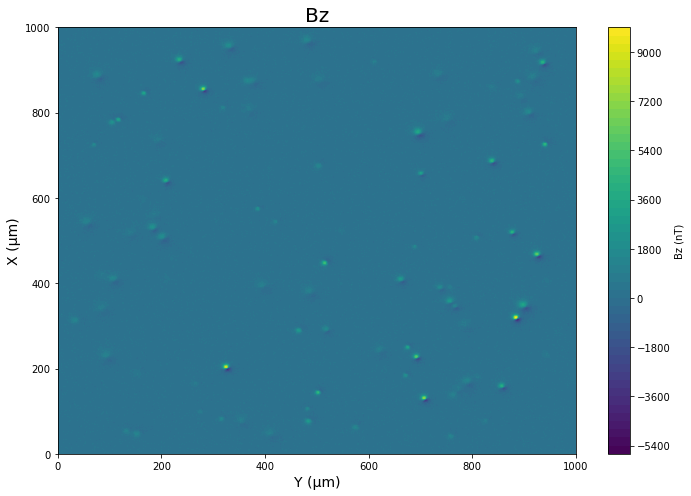

In [5]:
xs = np.linspace(area[0], area[1], shape[0])
ys = np.linspace(area[2], area[3], shape[1])

x_plot = np.reshape(Y,(np.size(xs),np.size(ys)))*m2microm
y_plot = np.reshape(X,(np.size(xs),np.size(ys)))*m2microm

# plot do mapa de dados do modelo direto

plt.figure(figsize=(10, 7))
plt.contourf(x_plot, y_plot, d_*10**9, levels=50, cmap='viridis')
plt.colorbar(label='Bz (nT)')

plt.title('Bz', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)

plt.tight_layout()

plt.show()

In [6]:
X_ = np.reshape(X, shape)
Y_ = np.reshape(Y, shape)
Z_ = np.reshape(Z, shape)


# calculating derivatives using Fast Fourier Transform (FFT)

wx, wy, wz = wave_numbers(d_, X_, Y_)

ddx = x_derivative_fft(d_, wx, order=1)
ddy = y_derivative_fft(d_, wy, order=1)
ddz = z_derivative_fft(d_, wz, order=1)

# calculating derivatives (x and y) using Finite Differences (FD)
d_X, d_Y = (derivative_fd(d_, X_,Y_, order=1))


In [7]:
# upward_continuation filtering --> to remove high frequency noise
height = 5.0      # delta_z upward continuation
delta_z = -height*microm2m
upward = upward_continuation(d_, delta_z, wz)


# upward_continuation --> used later to calculate the Z derivative by FD
delta_z1 = -(height-0.1)*microm2m
upward1 = upward_continuation(d_, delta_z1, wz)

delta_z2 = -(height+0.1)*microm2m
upward2 = upward_continuation(d_, delta_z2, wz)

Text(0, 0.5, 'X (µm)')

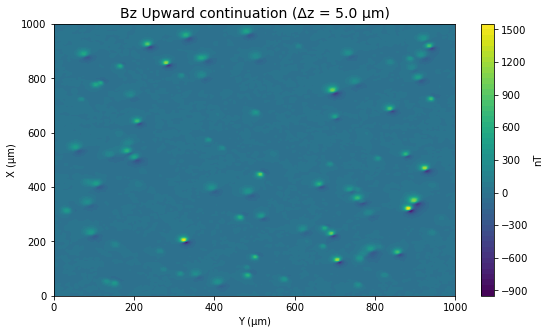

In [8]:
# upward continuation plot

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, (upward)*10**9, levels=50, cmap='viridis')
plt.colorbar(label='nT')

plt.title('Bz Upward continuation (Δz = %s µm)'%height, fontsize=14)
plt.xlabel('Y (µm)', fontsize=10)
plt.ylabel('X (µm)', fontsize=10)


In [9]:
# Novas derivadas (em x e y) usando a continuação p/ cima por FD
d_X, d_Y = (derivative_fd(upward, X_,Y_))
d_Z = z_derivative_fd(upward1, upward2, delta_z1, delta_z2)

In [10]:
Total_Grad_FD = Total_Grad(d_Y , d_X, d_Z)

Text(0, 0.5, 'X (µm)')

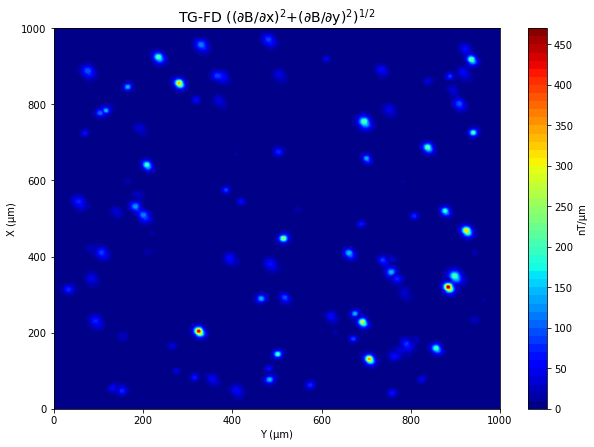

In [11]:
fig, ((ax1)) = plt.subplots(1,1, figsize=(10,7))

# plot FD horizontal gradient 
ax1_plot  = ax1.contourf(x_plot, y_plot, Total_Grad_FD*10**3, levels=50, cmap='jet')
plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
ax1.set_title('TG-FD'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=14)
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

Text(0, 0.5, 'Count')

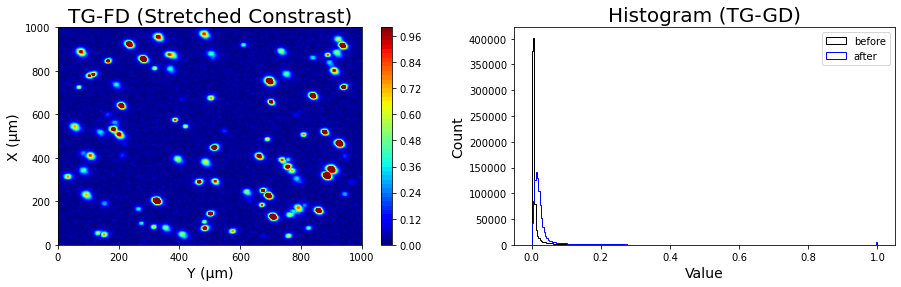

In [12]:
import skimage
import scipy.signal as signal

image =  Total_Grad_FD/Total_Grad_FD.max()

perc_min, perc_max = np.percentile(image, (0.5,99.5))
stretched_image = skimage.exposure.rescale_intensity(image, in_range=(perc_min, perc_max))



fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(15,4))

ax1_plot = ax1.contourf(x_plot, y_plot, stretched_image, levels=50, cmap='jet')
ax1.set_title('TG-FD (Stretched Constrast)', fontsize=20)
ax1.set_xlabel('Y (µm)', fontsize=14)
ax1.set_ylabel('X (µm)', fontsize=14)

plt.colorbar(ax1_plot, ax=ax1)

ax2.hist(image.ravel(), bins=256, histtype='step', color='k', label='before');
ax2.hist(stretched_image.ravel(), bins=256, histtype='step', color='b', label='after');
ax2.legend()
ax2.set_title('Histogram (TG-GD)', fontsize=20)
ax2.set_xlabel('Value', fontsize=14)
ax2.set_ylabel('Count', fontsize=14)


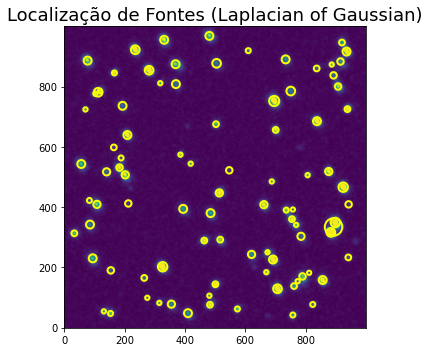

(89, 4)


()

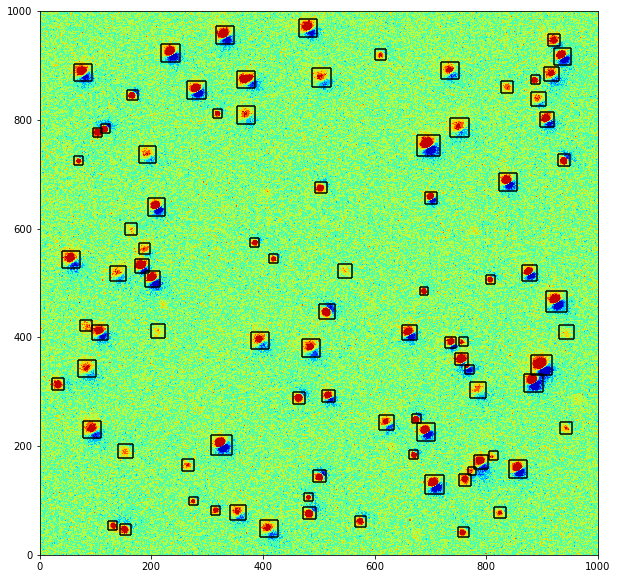

In [13]:
circles_FD, euler_windows_FD = sources_finder(stretched_image, threshold=0.05, min_sigma=5, max_sigma=30, num_sigma=30, overlap=1.0, radius_increment=0.2)
print(np.shape(euler_windows_FD))

Xc_FD, Yc_FD, Zc_FD, filtered_euler_windows_FD = solve_euler_windows(euler_windows_FD, X_, Y_, Z_, upward, d_X, d_Y, d_Z, delta_z, structural_index = 3.0)

import skimage
perc_min, perc_max = np.percentile(d_, (0.5,99.5))
view = skimage.exposure.rescale_intensity(d_, in_range=(perc_min, perc_max))
euler_windows_view(X_, Y_, Z_, view, filtered_euler_windows_FD, show_windows=False, color='k')


Euler Solutions:
    Xc (µm)   Yc (µm)  Zc (µm)
0  201.9996  326.0082   1.0044
1  129.0219  708.1109   1.0625
2  853.9575  281.8612   1.0315
3  466.0543  926.0403   2.0673
4  685.0228  838.9562   2.0972

Original Positions:
   Xc (µm)  Yc (µm)  Zc (µm)
0    251.0    676.0      1.0
1    525.0    549.0      8.0
2    546.0    421.0      2.0
3    414.0    214.0      9.0
4    877.0    367.0      5.0



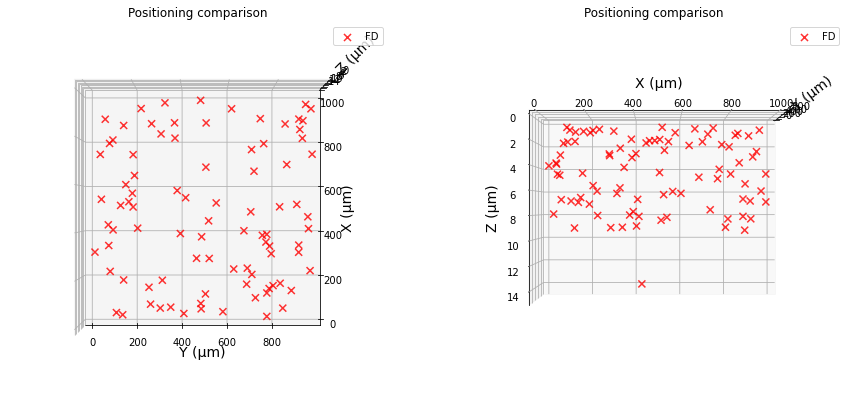

In [14]:
import pandas as pd
print('Euler Solutions:')
df1 = pd.DataFrame(data={'Xc (µm)': (np.round(Xc_FD*m2microm, decimals=4)),
                        'Yc (µm)': (np.round(Yc_FD*m2microm, decimals=4)),
                        'Zc (µm)': (np.round(Zc_FD*m2microm, decimals=4))
                       })

print(df1.head(5))
print()

print('Original Positions:')
df2 = pd.DataFrame(data={
                        'Xc (µm)': (np.round(Xc*m2microm, decimals=4)),
                        'Yc (µm)': (np.round(Yc*m2microm, decimals=4)),
                        'Zc (µm)': (np.round(Zc*m2microm, decimals=4))
                       })

print(df2.head(5))
print()

from mpl_toolkits.mplot3d import axes3d


fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.scatter(Yc_FD*m2microm, Xc_FD*m2microm, Zc_FD*m2microm,
            alpha=0.8, color='r', marker='x', s=50, label='FD')

ax1.set_title('Positioning comparison')
ax1.legend(loc='best')
ax1.invert_zaxis()

ax1.set_xlabel('Y (µm)', fontsize=14)
ax1.set_ylabel('X (µm)', fontsize=14)
ax1.set_zlabel('Z (µm)', fontsize=14)

ax1.azim = -90
ax1.dist = 10
ax1.elev = 90



ax2.scatter(Yc_FD*m2microm, Xc_FD*m2microm, Zc_FD*m2microm,
            alpha=0.8, color='r', marker='x', s=50, label='FD')

ax2.set_title('Positioning comparison')
ax2.legend(loc='best')
ax2.invert_zaxis()

ax2.set_xlabel('Y (µm)', fontsize=14)
ax2.set_ylabel('X (µm)', fontsize=14)
ax2.set_zlabel('Z (µm)', fontsize=14)

ax2.azim = 0
ax2.dist = 10
ax2.elev = 0

plt.show()

# Magnetic inversion using lest square method


,Dec (°),$\sigma D$ (°),Inc (°),$\sigma I$ (°),m ($A \cdot m^2$),$\sigma m$ ($A \cdot m^2$),Xc (µm),Yc (µm),Zc (µm)
0,149.8311,0.1679,14.6652,0.1184,1.759704e-14,4.906850e-17,201.999622,326.008239,1.004407
1,149.4788,0.2091,14.6615,0.1476,1.439849e-14,5.002350e-17,129.021918,708.110926,1.062484
2,150.8858,0.2185,15.3786,0.1541,1.368690e-14,4.943320e-17,853.957498,281.861217,1.031535
3,150.0785,0.2187,15.3912,0.1543,1.877638e-14,6.787020e-17,466.054281,926.040342,2.067265
4,150.2983,0.3125,15.5143,0.2204,1.326070e-14,6.842272e-17,685.022811,838.956218,2.097210
...,...,...,...,...,...,...,...,...,...
79,50.1566,3.9208,48.6854,2.2891,3.462411e-15,1.325408e-16,234.651884,944.774219,5.633566
80,67.7227,3.8381,52.0419,2.1344,2.341150e-15,8.023429e-17,391.566398,758.444312,3.326243
81,94.0087,2.6224,31.3681,1.7825,4.278596e-15,1.552811e-16,566.164533,194.292632,5.984317
82,82.1621,4.1697,18.2770,2.9378,2.693737e-15,1.842105e-16,178.822097,820.437792,6.568097


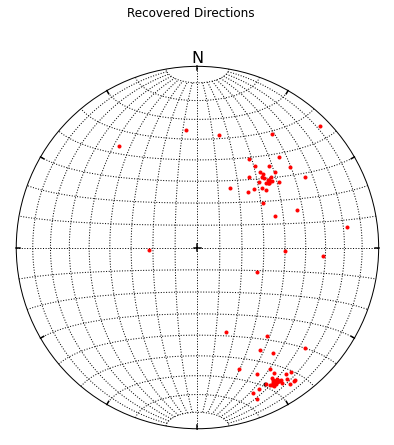

In [15]:
error = 0.05
d = np.squeeze(d)

# Magnetic inversion using FD euler positions and magnetic data before the upward continuation
hx_FD_least, hy_FD_least, hz_FD_least, M_FD_least, direct_model_FD_least = least_square_solver(X, Y, Z, Xc_FD, Yc_FD, Zc_FD, d)
D_FD_least, I_FD_least = directions(hx_FD_least, hy_FD_least, hz_FD_least, plot=True, show_mean=False, show_alpha95=False)


momentum_FD_least = (np.sqrt(hx_FD_least**2 + hy_FD_least**2 + hz_FD_least**2))


#Inversion uncertainties
sigma_noise = (np.absolute(np.max(d))+np.absolute(np.min(d))) * error
sigma_noise = 150*1.0e-9 # noise of 150 nT
sigma_D_FD_least, sigma_I_FD_least, sigma_m_FD_least = uncertainties(sigma_noise, M_FD_least, hx_FD_least, hy_FD_least, hz_FD_least)

import pandas as pd
df = pd.DataFrame(data={'Dec (°)': (np.round(D_FD_least, decimals=4)),
                        '$\sigma D$ (°)':    (np.round(sigma_D_FD_least, decimals=4)),
                        'Inc (°)': (np.round(I_FD_least, decimals=4)),
                        '$\sigma I$ (°)':    (np.round(sigma_I_FD_least, decimals=4)),
                        'm  ($A \cdot m^2$)':  (momentum_FD_least),
                        '$\sigma m$ ($A \cdot m^2$)':  (sigma_m_FD_least),
                        'Xc (µm)': Xc_FD*m2microm,
                        'Yc (µm)': Yc_FD*m2microm,
                        'Zc (µm)': Zc_FD*m2microm
                        
                       })

df.head(-5)



# Direct Model and Errors

### Whole Area

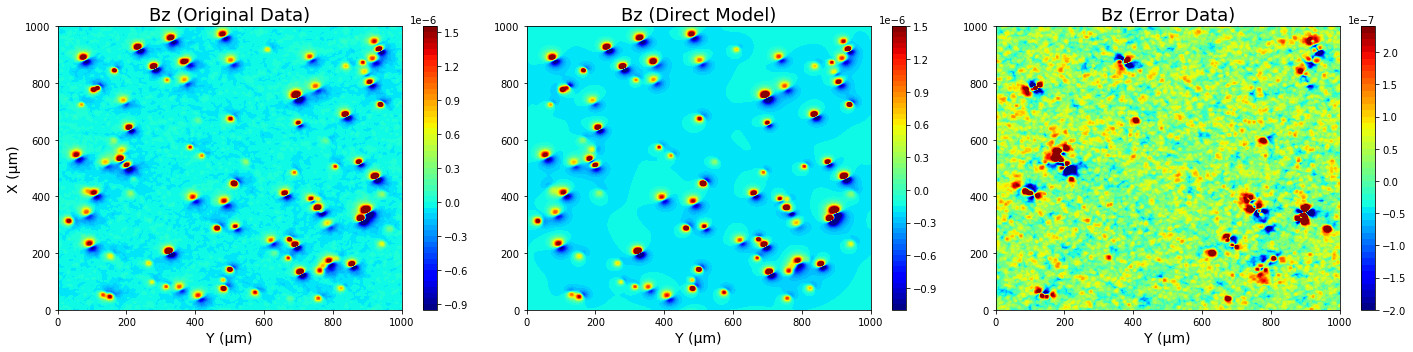

In [16]:
direct_model_FD_least = np.reshape(direct_model_FD_least, shape)

upward_direct_model_FD_least = upward_continuation(direct_model_FD_least, delta_z, wz)

fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(20,5))

perc_min, perc_max = np.percentile(upward, (0.5,99.5))
original_data_view = skimage.exposure.rescale_intensity(upward, in_range=(perc_min, perc_max))
ax4_plot = ax1.contourf(x_plot, y_plot, upward, levels=50, cmap='jet')
ax1_plot = ax1.contourf(x_plot, y_plot, original_data_view, levels=50, cmap='jet')

plt.colorbar(ax4_plot, ax=ax1)
ax1.set_title('Bz (Original Data)', fontsize=18)
ax1.set_xlabel('Y (µm)', fontsize=14)
ax1.set_ylabel('X (µm)', fontsize=14)


perc_min, perc_max = np.percentile(upward_direct_model_FD_least, (0.5,99.5))
direct_model_view = skimage.exposure.rescale_intensity(upward_direct_model_FD_least, in_range=(perc_min, perc_max))
ax5_plot = ax2.contourf(x_plot, y_plot, upward_direct_model_FD_least, levels=50, cmap='jet')
ax2_plot = ax2.contourf(x_plot, y_plot, direct_model_view, levels=50, cmap='jet')
plt.colorbar(ax5_plot, ax=ax2)
ax2.set_title('Bz (Direct Model)', fontsize=18)
ax2.set_xlabel('Y (µm)', fontsize=14)

error = upward - upward_direct_model_FD_least
perc_min, perc_max = np.percentile(error, (0.5,99.5))
error_data_view = skimage.exposure.rescale_intensity(error, in_range=(perc_min, perc_max))
ax6_plot = ax3.contourf(x_plot, y_plot, error, levels=50, cmap='jet')
ax3_plot = ax3.contourf(x_plot, y_plot, error_data_view, levels=50, cmap='jet')
plt.colorbar(ax6_plot, ax=ax3)
ax3.set_title('Bz (Error Data)', fontsize=18)
ax3.set_xlabel('Y (µm)', fontsize=14)



plt.tight_layout()

#plt.savefig('teste.jpg', dpi=500)

### For each Window

In [18]:
Xc_save, Yc_save, Zc_save = [], [], []
hx_save, hy_save, hz_save = [], [], []
m_save, D_save, I_save = [], [], []
sigma_m_save, sigma_D_save, sigma_I_save = [], [], []
deter_coef_save = []

show=False


for i in range(np.shape(filtered_euler_windows_FD)[0]):
    
    if Zc_FD[i]>=0:
        x1, x2 = int(euler_windows_FD[i,0]), int(euler_windows_FD[i,1])
        y1, y2 = int(euler_windows_FD[i,2]), int(euler_windows_FD[i,3])

        data_normalized = upward[x1:x2, y1:y2]/(np.absolute(np.max(upward[x1:x2, y1:y2])
                                                         -np.min(upward[x1:x2, y1:y2])))

        model_normalized = (upward_direct_model_FD_least[x1:x2, y1:y2]/
                            (np.absolute(np.max(upward_direct_model_FD_least[x1:x2, y1:y2])
                            -np.min(upward_direct_model_FD_least[x1:x2, y1:y2]))) )

        error_normalized = data_normalized-model_normalized

        SQ_tot = np.sum( (data_normalized-np.mean(data_normalized))**2 )
        SQ_res = np.sum( (data_normalized-model_normalized)**2 )
        deter_coef = 1 - (SQ_res/SQ_tot)
        

        momentum = (np.sqrt(hx_FD_least[i]**2 + hy_FD_least[i]**2 + hz_FD_least[i]**2))
        Xc_save.append(Xc_FD[i]*m2microm)
        Yc_save.append(Yc_FD[i]*m2microm)
        Zc_save.append(Zc_FD[i]*m2microm)
        hx_save.append(hx_FD_least[i])
        hy_save.append(hy_FD_least[i])
        hz_save.append(hz_FD_least[i])
        m_save.append(momentum)
        sigma_m_save.append(sigma_m_FD_least[i])
        D_save.append(D_FD_least[i])
        sigma_D_save.append(sigma_D_FD_least[i])
        I_save.append(I_FD_least[i])
        sigma_I_save.append(sigma_I_FD_least[i])
        deter_coef_save.append(deter_coef)

        if show:
            print('R2: ', deter_coef)

            fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(20,5))

            ax1_plot = ax1.contourf(x_plot[x1:x2, y1:y2], y_plot[x1:x2, y1:y2], 
                                    upward[x1:x2, y1:y2], levels=50, cmap='viridis')
            plt.colorbar(ax1_plot, ax=ax1)
            ax1.set_title('Bz (Original Data)', fontsize=18)
            ax1.set_xlabel('Y (µm)', fontsize=14)
            ax1.set_ylabel('X (µm)', fontsize=14)


            ax2_plot = ax2.contourf(x_plot[x1:x2, y1:y2], y_plot[x1:x2, y1:y2], 
                                    upward_direct_model_FD_least[x1:x2, y1:y2], levels=50, cmap='viridis')
            plt.colorbar(ax2_plot, ax=ax2)
            ax2.set_title('Bz (Direct Model)', fontsize=18)
            ax2.set_xlabel('Y (µm)', fontsize=14)

            error = upward[x1:x2, y1:y2] - upward_direct_model_FD_least[x1:x2, y1:y2]
            ax3_plot = ax3.contourf(x_plot[x1:x2, y1:y2], y_plot[x1:x2, y1:y2], error, levels=50, cmap='viridis')
            plt.colorbar(ax3_plot, ax=ax3)
            ax3.set_title('Bz (Error Data)', fontsize=18)
            ax3.set_xlabel('Y (µm)', fontsize=14)

            plt.tight_layout()
            plt.show()

                    
df_final = pd.DataFrame(data={'Xc (µm)': np.array(np.round(Xc_save, decimals=4)),
                              'Yc (µm)': np.array(np.round(Yc_save, decimals=4)),
                              'Zc (µm)': np.array(np.round(Zc_save, decimals=4)),
                              'mx (Am2)': np.array(hx_save),
                              'my (Am2)': np.array(hy_save),
                              'mz (Am2)': np.array(hz_save),
                              'm (Am2)': np.array(m_save),
                              'sigma m (Am2)': np.array(sigma_m_save),
                              'D (°)': np.array(D_save),
                              'sigma D (°)': np.array(sigma_D_save),
                              'I (°)': np.array(I_save),
                              'sigma I (°)': np.array(sigma_I_save),
                              'R2': np.array(deter_coef_save)

                       })

In [19]:
df_final.head(-5)
display(df_final)

,Xc (µm),Yc (µm),Zc (µm),mx (Am2),my (Am2),mz (Am2),m (Am2),sigma m (Am2),D (°),sigma D (°),I (°),sigma I (°),R2
0,201.9996,326.0082,1.0044,-1.471785e-14,8.555294e-15,4.455055e-15,1.759704e-14,4.906850e-17,149.831125,0.167858,14.665219,0.118450,0.999449
1,129.0219,708.1109,1.0625,-1.199957e-14,7.074273e-15,3.644384e-15,1.439849e-14,5.002350e-17,149.478795,0.209140,14.661543,0.147576,0.999662
2,853.9575,281.8612,1.0315,-1.152943e-14,6.420941e-15,3.629714e-15,1.368690e-14,4.943320e-17,150.885805,0.218497,15.378617,0.154118,0.999507
3,466.0543,926.0403,2.0673,-1.569004e-14,9.030006e-15,4.983391e-15,1.877638e-14,6.787020e-17,150.078506,0.218688,15.391162,0.154250,0.999639
4,685.0228,838.9562,2.0972,-1.109878e-14,6.331068e-15,3.546951e-15,1.326070e-14,6.842272e-17,150.298300,0.312454,15.514272,0.220372,0.999495
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,603.2255,166.2790,6.1416,2.070517e-15,1.347075e-15,1.192207e-15,2.742811e-15,1.635101e-16,33.047955,3.985382,25.764060,2.766648,0.861650
85,427.1278,73.5942,14.0553,6.986500e-15,-5.384414e-15,5.020320e-15,1.014922e-14,4.732219e-16,-37.621022,3.287796,29.646723,2.245305,-0.113866
86,415.1629,213.3503,8.1331,2.245809e-15,1.306262e-15,2.431268e-15,3.558236e-15,2.089040e-16,30.184172,5.261921,43.100410,3.290341,0.973779
87,412.6401,946.5172,8.8320,2.644771e-15,2.373330e-15,2.280641e-15,4.222420e-15,2.446412e-16,41.903757,4.268020,32.692250,2.886787,0.977280


### Filtering data by: deternation coef. (R$^2$), $\sigma$D and $\sigma$I 

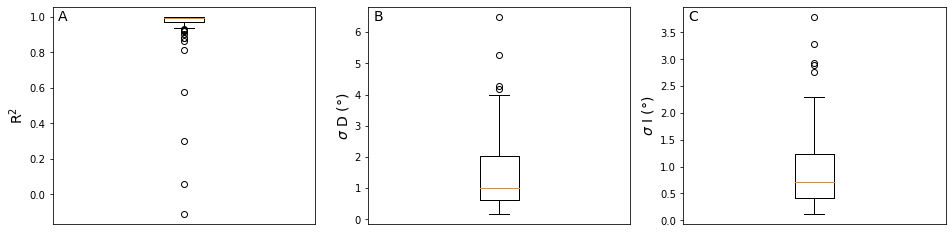

In [20]:
fig, axes = plt.subplots(1,3, figsize=(16,4))
axes[0].boxplot(df_final['R2'])
axes[0].set_xticks([])
axes[0].set_ylabel('R$^2$', fontsize=14)
ytext = df_final['R2'].max()
axes[0].text(0.52, ytext-0.02*ytext, 'A', fontsize=14)

axes[1].boxplot(df_final['sigma D (°)'])
axes[1].set_xticks([])
axes[1].set_ylabel('$\sigma$ D (°)', fontsize=14)
ytext = df_final['sigma D (°)'].max()
axes[1].text(0.52, ytext-0.02*ytext, 'B', fontsize=14)

axes[2].boxplot(df_final['sigma I (°)'])
axes[2].set_xticks([])
axes[2].set_ylabel('$\sigma$ I (°)', fontsize=14)
ytext = df_final['sigma I (°)'].max()
axes[2].text(0.52, ytext-0.02*ytext, 'C', fontsize=14)

plt.show()

#### Directions Recovered

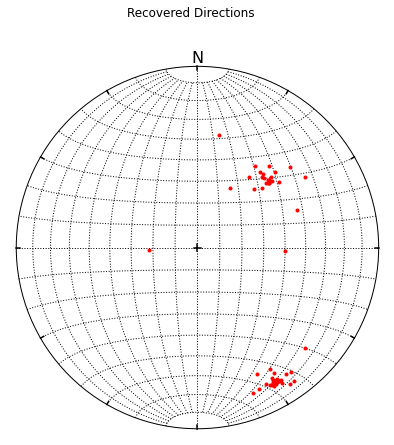

In [25]:
index = ((df_final['R2']>=0.96) & (df_final['sigma D (°)']<=4) & (df_final['sigma I (°)']<=2))
h=df_final[index]



D, I = directions(np.array(h['mx (Am2)']), np.array(h['my (Am2)']), np.array(h['mz (Am2)']), plot=True, show_mean=False, show_alpha95=False)

#### Momentum Recovered

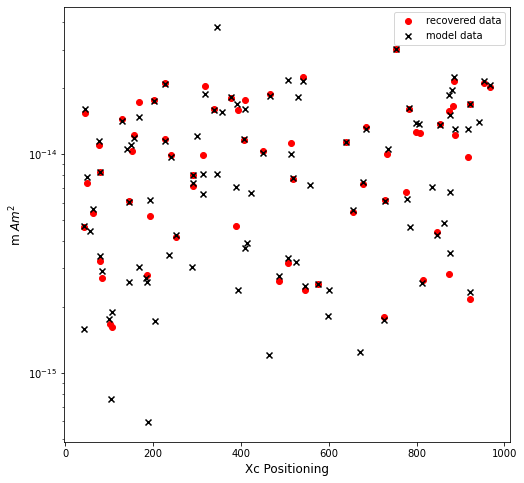

In [26]:
plt.figure(figsize=(8,8))
plt.scatter(h['Xc (µm)'], h['m (Am2)'], label='recovered data', color='r')

m_real = Q*4/3*np.pi*R**3
plt.scatter(Xc*m2microm, m_real, marker='x', label='model data', color='k')
plt.yscale('log')

plt.xlabel('Xc Positioning', fontsize=12)
plt.ylabel('m $Am^{2}$', fontsize=12)

plt.legend(loc='best')